In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

df = pd.read_csv('../data/benchmark_dataset.csv')

# Columns to exclude
exclude_cols = [
    'Uploaded_variation', 'level_1', 'Location', 'Allele', 'Gene',
    'Feature', 'Feature_type', 'Consequence',
    'cDNA_position', 'CDS_position', 'Protein_position', 'Amino_acids',
    'Codons', 'Existing_variation', 'IMPACT', 'DISTANCE',
    'STRAND', 'FLAGS', 'ClinicalSignificance', 'label', 'CANONICAL'
]

# Keep features for training
df_numeric = df.drop(columns=[col for col in exclude_cols if col in df.columns], errors='ignore')
df_numeric = df_numeric.select_dtypes(include=[np.number])

# Print feature names
print(df_numeric.columns.tolist())


['AllofUs_ALL_AF', 'AlphaMissense_score', 'BayesDel_addAF_score', 'BayesDel_noAF_score', 'CADD_raw', 'ClinPred_score', 'DANN_score', 'DEOGEN2_score', 'ESM1b_score', 'Eigen-PC-raw_coding', 'Eigen-raw_coding', 'GERP++_RS', 'GERP_91_mammals', 'M-CAP_score', 'MPC_score', 'MVP_score', 'MetaLR_score', 'MetaRNN_score', 'MetaSVM_score', 'MutFormer_score', 'MutScore_score', 'MutationAssessor_score', 'MutationTaster_score', 'PROVEAN_score', 'Polyphen2_HDIV_score', 'Polyphen2_HVAR_score', 'PrimateAI_score', 'REVEL_score', 'RegeneronME_ALL_AF', 'SIFT4G_score', 'SIFT_score', 'VEST4_score', 'bStatistic', 'dbNSFP_POPMAX_AF', 'fathmm-XF_coding_score', 'gMVP_score', 'gnomAD4.1_joint_AF', 'phastCons100way_vertebrate', 'phastCons17way_primate', 'phastCons470way_mammalian', 'phyloP100way_vertebrate', 'phyloP17way_primate', 'phyloP470way_mammalian']


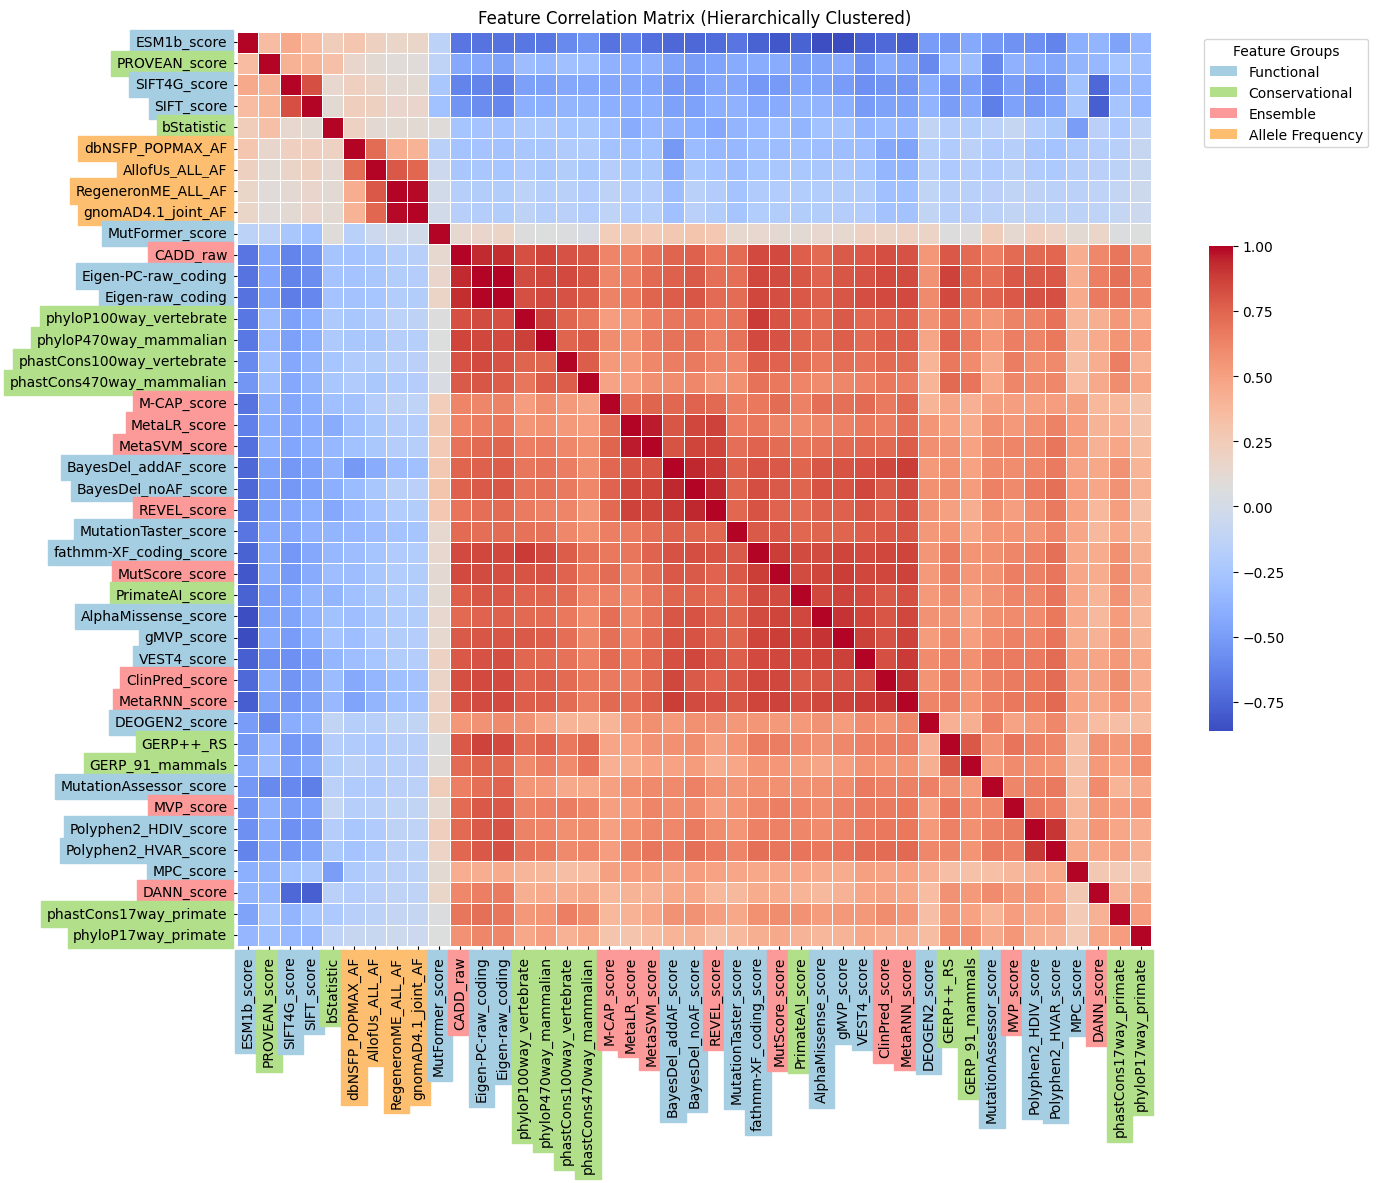

In [3]:
from scipy.cluster.hierarchy import linkage, leaves_list

# Compute correlation matrix again (same feature list)
corr = df_numeric[features].corr()

# Hierarchical clustering on correlation matrix
linkage_matrix = linkage(corr, method='average')
leaf_order = leaves_list(linkage_matrix)
clustered_features = corr.columns[leaf_order]
clustered_corr = corr.loc[clustered_features, clustered_features]

# Get reordered group colors
feature_to_group = dict(zip(features, groups))
clustered_colors = [palette[feature_to_group[f]] for f in clustered_features]

# Plot clustered heatmap
plt.figure(figsize=(14, 12))
ax = sns.heatmap(clustered_corr, cmap='coolwarm', xticklabels=True, yticklabels=True,
                 square=True, cbar_kws={"shrink": .5}, linewidths=0.5)

plt.xticks(rotation=90)
plt.yticks(rotation=0)

for idx, tick in enumerate(ax.get_xticklabels()):
    tick.set_backgroundcolor(clustered_colors[idx])
for idx, tick in enumerate(ax.get_yticklabels()):
    tick.set_backgroundcolor(clustered_colors[idx])

from matplotlib.patches import Patch
legend = [Patch(facecolor=palette[g], label=g) for g in palette]
plt.legend(handles=legend, title="Feature Groups", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title("Feature Correlation Matrix (Hierarchically Clustered)")
plt.tight_layout()
plt.show()


In [4]:
# Compute high correlation pairs (positive, negative, absolute)

# Set correlation threshold
threshold = 0.8

# Positive correlations (r > +0.8)
pos_pairs = np.where(np.triu(corr.values, k=1) > threshold)
pos_corr_pairs = [(corr.index[i], corr.columns[j], corr.values[i, j]) for i, j in zip(*pos_pairs)]

# Negative correlations (r < -0.8)
neg_pairs = np.where(np.triu(corr.values, k=1) < -threshold)
neg_corr_pairs = [(corr.index[i], corr.columns[j], corr.values[i, j]) for i, j in zip(*neg_pairs)]

# Absolute correlations (|r| > 0.8)
abs_corr = corr.abs().copy()
abs_pairs = np.where(np.triu(abs_corr.values, k=1) > threshold)
abs_corr_pairs = [(corr.index[i], corr.columns[j], corr.values[i, j]) for i, j in zip(*abs_pairs)]

# Summary counts
print(f"Strong positive correlations (r > +{threshold}): {len(pos_corr_pairs)} pairs")
print(f"Strong negative correlations (r < -{threshold}): {len(neg_corr_pairs)} pairs")
print(f"Total high correlations (|r| > {threshold}): {len(abs_corr_pairs)} pairs\n")

# List unique features involved in each type
pos_features = sorted(set([a for a, _, _ in pos_corr_pairs] + [b for _, b, _ in pos_corr_pairs]))
neg_features = sorted(set([a for a, _, _ in neg_corr_pairs] + [b for _, b, _ in neg_corr_pairs]))
abs_features = sorted(set([a for a, _, _ in abs_corr_pairs] + [b for _, b, _ in abs_corr_pairs]))

print(f"Features in positive correlations: {len(pos_features)}")
print(pos_features[:15])
print()
print(f"Features in negative correlations: {len(neg_features)}")
print(neg_features[:15])
print()
print(f"Features in total |r|>{threshold}: {len(abs_features)} / {len(features)} features\n")

# Create summary DataFrame
summary_df = (
    pd.DataFrame(abs_corr_pairs, columns=['feature_1', 'feature_2', 'r'])
    .assign(sign=lambda d: np.where(d['r'] > 0, 'positive', 'negative'),
            abs_r=lambda d: d['r'].abs())
    .sort_values('abs_r', ascending=False)
    .reset_index(drop=True)
)

# Display top correlated pairs
summary_df.head(30)


Strong positive correlations (r > +0.8): 91 pairs
Strong negative correlations (r < -0.8): 3 pairs
Total high correlations (|r| > 0.8): 94 pairs

Features in positive correlations: 27
['AlphaMissense_score', 'BayesDel_addAF_score', 'BayesDel_noAF_score', 'CADD_raw', 'ClinPred_score', 'Eigen-PC-raw_coding', 'Eigen-raw_coding', 'GERP++_RS', 'MetaLR_score', 'MetaRNN_score', 'MetaSVM_score', 'MutScore_score', 'MutationTaster_score', 'Polyphen2_HDIV_score', 'Polyphen2_HVAR_score']

Features in negative correlations: 4
['AlphaMissense_score', 'ESM1b_score', 'MutScore_score', 'gMVP_score']

Features in total |r|>0.8: 28 / 43 features



,feature_1,feature_2,r,sign,abs_r
0,Eigen-PC-raw_coding,Eigen-raw_coding,0.995486,positive,0.995486
1,RegeneronME_ALL_AF,gnomAD4.1_joint_AF,0.990853,positive,0.990853
2,MetaLR_score,MetaSVM_score,0.958794,positive,0.958794
3,BayesDel_noAF_score,REVEL_score,0.936492,positive,0.936492
4,BayesDel_addAF_score,BayesDel_noAF_score,0.935767,positive,0.935767
5,Eigen-PC-raw_coding,CADD_raw,0.930830,positive,0.930830
6,Eigen-raw_coding,CADD_raw,0.923651,positive,0.923651
7,ClinPred_score,MetaRNN_score,0.919676,positive,0.919676
8,AlphaMissense_score,gMVP_score,0.905456,positive,0.905456
9,Polyphen2_HDIV_score,Polyphen2_HVAR_score,0.903363,positive,0.903363


In [5]:
# Load Top-10 SHAP tables
varity_t10 = pd.read_csv('../models/varity/varity_project/output/csv/shap_top10_varity.csv').assign(model='VARITY')
mvp_t10    = pd.read_csv('../models/missense/results/shap_top10_mvp.csv').assign(model='MVP')
mut_t10    = pd.read_csv('../models/MutScore/benchmark/data/shap_top10_mutscore.csv').assign(model='MutScore')

top10_all = pd.concat([varity_t10, mvp_t10, mut_t10], ignore_index=True)

# Flag high-corr membership (|r| > threshold)
top10_all['is_high_corr'] = top10_all['feature'].isin(abs_features)

# Per-model counts and ratios
summary_counts = (
    top10_all.groupby('model')['is_high_corr']
    .agg(n_high_corr='sum', total='count')
    .assign(ratio=lambda d: d['n_high_corr'] / d['total'])
    .reset_index()
)

# Print concise summary lines
for _, row in summary_counts.iterrows():
    print(f"{row['model']}: {int(row['n_high_corr'])} of {int(row['total'])} "
          f"Top-10 features in |r| > {threshold} set "
          f"({row['ratio']:.1%}).")

summary_counts


MVP: 7 of 10 Top-10 features in |r| > 0.8 set (70.0%).
MutScore: 10 of 10 Top-10 features in |r| > 0.8 set (100.0%).
VARITY: 7 of 10 Top-10 features in |r| > 0.8 set (70.0%).


,model,n_high_corr,total,ratio
0,MVP,7,10,0.7
1,MutScore,10,10,1.0
2,VARITY,7,10,0.7


In [6]:
# Load Top-5 lists
varity_t5 = pd.read_csv('../models/varity/varity_project/output/csv/shap_top5_varity.csv').assign(model='VARITY')
mvp_t5    = pd.read_csv('../models/missense/results/shap_top5_mvp.csv').assign(model='MVP')
mut_t5    = pd.read_csv('../models/MutScore/benchmark/data/shap_top5_mutscore.csv').assign(model='MutScore')

t5_all = pd.concat([varity_t5, mvp_t5, mut_t5], ignore_index=True)

# Add high-corr flag
t5_all['High Corr (|r|>' + str(threshold) + ')'] = t5_all['feature'].isin(abs_features)

# Round SHAP values to 4 decimals for reporting
t5_all['mean_abs_shap'] = t5_all['mean_abs_shap'].astype(float).round(4)

# Reorder columns and save Appendix table
appendix_table = t5_all[['model', 'feature', 'mean_abs_shap', 'High Corr (|r|>' + str(threshold) + ')']]

appendix_table.to_csv('../data/appendix_top5_shap_all_models.csv', index=False)

# Preview
appendix_table


,model,feature,mean_abs_shap,High Corr (|r|>0.8)
0,VARITY,phyloP100way_vertebrate,1.6993,True
1,VARITY,MutationTaster_score,1.3581,True
2,VARITY,ClinPred_score,0.8516,True
3,VARITY,dbNSFP_POPMAX_AF,0.3202,False
4,VARITY,GERP++_RS,0.3021,True
5,MVP,Polyphen2_HVAR_score,0.0072,True
6,MVP,gMVP_score,0.0038,True
7,MVP,MetaRNN_score,0.0037,True
8,MVP,phastCons470way_mammalian,0.0035,False
9,MVP,AlphaMissense_score,0.0033,True
